# Deep Learning for chemistry
This weeks task is structured around the 2018 Nomad challenge on Kaggle, an online machine learning platform wiht many tutorial and open data science competitions. For this we require several deep learning and data science libraries as well as the dataset from the competition, containing the data of 2400 $(Al_xGa_yIn_z)_2O_3$ crystals.

In [1]:
#!pip install --upgrade pip
#!pip install pandas
#!pip install seaborn
#!pip install tensorflow
#!pip install keras
#!pip install scikit-learn
#!pip install ase

The dataset can be cloned from a github repository. 

In [2]:
!git clone https://github.com/csutton7/nomad_2018_kaggle_dataset.git

fatal: destination path 'nomad_2018_kaggle_dataset' already exists and is not an empty directory.


Know we want to import all relevant modules: 
* Seaborn and pandas provide functionalities for the manipulation and visualization of large datasets
* Kears provides neural network functions as a wrapper for Tensorflow
* SKlearn is a machine learning library with several important functionalities
* Atomic simulation environment (ASE) is a chemistry package which allows you to easily load and manipulate chemichal data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import keras
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from ase.io.aims import read_aims

2023-11-23 12:56:26.411963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 12:56:26.412002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 12:56:26.413118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 12:56:26.419460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 12:56:27.138494: W tensorflow/compiler/tf2

As a first step, we have to load our data. Fortunately, we can use Pandas to directly load the data from a .csv file as a dataframe.

In [4]:
# Load dataset with pandas
train_df = pd.read_csv("train.csv")

How does our data look like? As you can see, we loaded strctural parameters of crystal structures together with the formation energy and the bandgap values of several semiconductors.

In [5]:
# View data 
train_df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


At this point, input and output is combinded in this dataset. Thus, we have to divide the features into input features, which are used as an input for the model and have to be known beforehand, and output features, which are the target of our model. 

In [6]:
#Seperate targets from inputs
Targets_df=pd.DataFrame()
Targets_df["bandgap_energy_ev"] = train_df["bandgap_energy_ev"].copy()
Targets_df["formation_energy_ev_natom"] = train_df["formation_energy_ev_natom"].copy()
# Delete targets from input data frame
train_df=train_df.drop(["formation_energy_ev_natom","bandgap_energy_ev"],axis=1) 
train_df=train_df.drop(["id"],axis=1)
# View targets 
Targets_df.head()

,bandgap_energy_ev,formation_energy_ev_natom
0,3.4387,0.0680
1,2.9210,0.2490
2,2.7438,0.1821
3,3.3492,0.2172
4,1.3793,0.0505


Our input data contains very different parameter, both in type and value. Thus, we have to think about how we present this data in the most informative way to our model before anything else. A typical approach in data preprocessing is to transform the data by e.g. using a relative value instead of absoulte quantities. Furthermore, categorical data like the spacegroup can be cast into a much more powerful representation by using a "one-hot-encoding", which means that every value is represented by a binary value (True/False, 1/0) in a vector.

In [7]:
# Center and rescale numerical data
numerical_df=pd.DataFrame.copy(train_df[['number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']])
numerical_df = (numerical_df-numerical_df.mean())/numerical_df.std()

# Use one-hot encoding for categorical data 
one_hot_df=pd.DataFrame.copy(train_df[["spacegroup"]])
# Basically, we want a colum for each spacegroup with a boolean index, for each datapoint exactly one entry is True
one_hot_df=pd.get_dummies(one_hot_df,prefix=["spacegroup"], columns=["spacegroup"])
features_df=pd.concat([numerical_df,one_hot_df],axis=1)

# Combine numerical and categorical data 
features_df=pd.concat([numerical_df,one_hot_df],axis=1)
features_df.head()

,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,spacegroup_12,spacegroup_33,spacegroup_167,spacegroup_194,spacegroup_206,spacegroup_227
0,0.810716,0.902077,0.284100,-1.162464,-0.013764,0.774639,-0.626664,-0.180756,-0.452225,-0.185009,False,True,False,False,False,False
1,0.810716,0.902077,0.284100,-1.162464,-0.681257,-0.477788,2.024569,-0.168758,-0.453036,0.974733,False,False,False,True,False,False
2,-0.959326,1.608115,-0.518151,-1.162464,-0.049421,-0.755147,0.251289,0.543719,-0.240799,-2.484453,False,False,False,False,False,True
3,-1.401836,1.372769,-1.320401,-0.212609,-0.890345,-1.102230,0.172181,-0.191103,-0.450413,0.974702,False,False,True,False,False,False
4,0.810716,-1.451382,1.353767,0.262319,-0.596693,-0.225240,2.199334,-0.185704,-0.452545,0.974223,False,False,False,True,False,False


Following the regulations of the [competition](https://www.kaggle.com/competitions/nomad2018-predict-transparent-conductors/overview), we use log-values for the prediction. As a baseline, we use a kernel based model as introduced in last weeks task. Since this kind of model is only capable of predicting a single output value, we have to train the model for both targets individually. 

In [8]:
# Transform to log 
Targets_df = np.log1p(Targets_df)
# Prepare training and test dataset
Y1 = Targets_df["bandgap_energy_ev"]
Y2 = Targets_df["formation_energy_ev_natom"]
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(features_df, Y1, test_size=0.2, random_state=2017)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(features_df, Y2, test_size=0.2, random_state=2017)

Since both models are trained individually, we have to combine both errors to get the total error of the approach.

In [9]:
# Defie Kernel with default settings
kernel1 = KernelRidge(kernel ='laplacian', alpha=1.0)
kernel2 = KernelRidge(kernel ='laplacian', alpha=1.0)

# Fit to data
kernel1.fit(X_train1,y_train1)
kernel2.fit(X_train2, y_train2)

# Get predictions on test data
kernel_preds1 = kernel1.predict(X_valid1)
kernel_preds2 = kernel2.predict(X_valid2)

# Get the root mean squared log error for comparison with competition 
rsme_valid1 = np.sqrt(mean_squared_error(y_valid1,kernel_preds1))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid2,kernel_preds2))

# Combine both errors for total error
rsme_total = np.sqrt(rsme_valid1 * rsme_valid1 + rsme_valid2 * rsme_valid2)

print('RSME for band gap:', rsme_valid1)
print('RSME for formation energy:', rsme_valid2)
print('RSME for total:', rsme_total)

RSME for band gap: 0.09314601571481751
RSME for formation energy: 0.031904880387260304
RSME for total: 0.09845862905845489


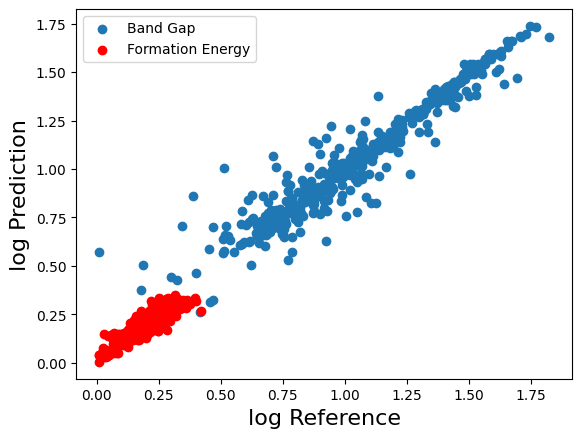

In [25]:
# Plot predictions vs. reference
plt.scatter(y_valid1, kernel_preds1, label="Band Gap")
plt.scatter(y_valid2, kernel_preds2, color="red", label="Formation Energy")
plt.xlabel("log Reference", fontsize=16)
plt.ylabel("log Prediction", fontsize=16)
plt.legend()
plt.show()

How can we do the same using a deep learning approach? First, we have to specify how our neural network is structured. For convenience, this can be done using a simple functions whihc helps to set up the strcture of the network. Take a look at the function and see how the number of input and output values is specified. Which parameters can we choose freely?

In [11]:
def generate_NN(n_layers, n_features, n_input, n_output, activation, optimizer, loss="mean_squared_error", reg=0.0):
    """
    Basic template to generate a deep neural network with uniform number of features, activation etc.
    ### Inputs ###
    n_layers: defining the total number of dense layers, int
    n_features: Number of perceptrons per layer, int
    n_output: Number of input features, int
    n_output: Number of output features, int
    activation: Activation function applied in each layer
    Optional: loss function, optimizer
    ### Output ###
    nn: Keras Neural Network
    """
    from keras.models import Sequential 
    from keras.layers import Dense, BatchNormalization
    from keras.regularizers import L2
    
    nn = Sequential() # Class for a sequential NN
    for i in range(n_layers):
        # Input layer == 0, start to define hidden layers 
        if i == 1:
            # Add input-layer connection
            nn.add(Dense(n_features, input_dim=n_input, activation=activation, kernel_regularizer=L2(reg)))
        elif i > 1:
            # Add layer-layer connection with uniform number of features 
            nn.add(Dense(n_features, input_dim=n_features, activation=activation, kernel_regularizer=L2(reg)))
    # Add an output layer 
    nn.add(Dense(n_output, input_dim=n_features))
    nn.compile(loss=loss, optimizer=optimizer)
    return nn

As a starting point, we use a shallow NN with only a single hidden layer.

In [12]:
# NN Parameter
n_features = 32            # Number of perceptrons per hidden layer
n_layers = 2               # Number of layers, 2 = 1 hidden, 1 output
learning_rate = 0.01       # Learning rate of the optimizer
regularization = 0.0001    # regularization parameter for the parameters
activation = "sigmoid"     # Non-linear activation function
iterations = 200           # Number of optimization epochs
batch_size = 20            # Mini-batch isze for the stochastic optimization
input_features = features_df.shape[-1]   # Number of Input parameters

The second ingredient for a NN approach is the optimizer for the stochastic optimization. As a starting point, we use the plain stochastic gradient descent algorithm for the optimization. 

In [13]:
# Initialize optimizer and model
optimizer = keras.optimizers.SGD(learning_rate=learning_rate) 
model = generate_NN(n_layers, n_features, input_features, 2, activation, optimizer, reg=regularization)

2023-11-23 12:56:28.860624: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In difference to a Kernel regression approach, we can predict both properties for a single model! In difference to a deterministic approach, a stochastic optimization can go on and on and on and on. Therefore we have to specify a stopping criterion, for example a maximum number of iterations. Here, we train for 100 iterations.

In [14]:
# Train model
X_train, X_valid, y_train, y_valid = train_test_split(features_df, Targets_df, test_size=0.2, random_state=2017)
output = model.fit(np.array(X_train).astype('float32'), np.array(y_train).astype('float32'), epochs=iterations, batch_size=batch_size)

Epoch 1/200
96/96 [==============================] - 0s 1ms/step - loss: 0.1059
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 3/200
96/96 [==============================] - 0s 951us/step - loss: 0.0400
Epoch 4/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 5/200
96/96 [==============================] - 0s 985us/step - loss: 0.0263
Epoch 6/200
96/96 [==============================] - 0s 970us/step - loss: 0.0228
Epoch 7/200
96/96 [==============================] - 0s 867us/step - loss: 0.0204
Epoch 8/200
96/96 [==============================] - 0s 909us/step - loss: 0.0186
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0174
Epoch 10/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 11/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 12/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 13/200
96/96 [=======

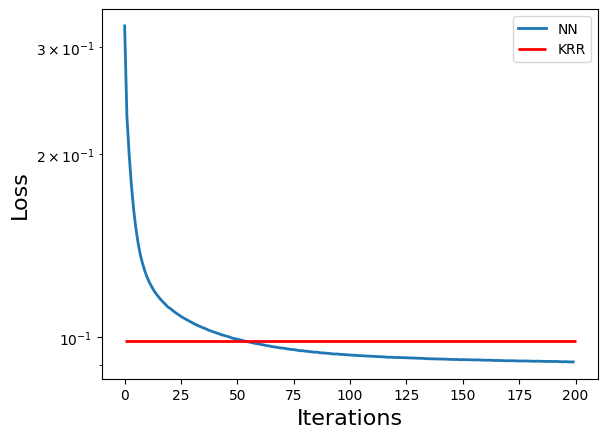

In [15]:
# The training dat is stored in the history of the output
output.history.keys()
# Plot the loss per iteration
loss=output.history["loss"]
plt.plot(np.sqrt(loss), label="NN", lw=2)
# Add Kernel loss as baseline, note that this loss was on the test set
plt.hlines(rsme_total, 0, 200, color="red", lw=2, label="KRR")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.yscale("log")
plt.legend()

Lets see how our model performs on the test set:

In [16]:
# Make predictions of test set
pred = model.predict(np.array(X_valid, dtype=np.float32))
# Calculate RMSLE
y_valid1 = np.array(y_valid)[:, 0]
y_valid2 = np.array(y_valid)[:, 1]
nn_preds1 = pred[:, 0]
nn_preds2 = pred[:, 1]
rsme_valid1 = np.sqrt(mean_squared_error(y_valid1,nn_preds1))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid2,nn_preds2))
# Get total error
rsme_total = np.sqrt(rsme_valid1*rsme_valid1+rsme_valid2*rsme_valid2)
print('RSME for formation energy:')
print(rsme_valid1)
print('RSME for band gap:')
print(rsme_valid2)
print('RSME for total:')
print(rsme_total)

15/15 [==============================] - 0s 730us/step
RSME for formation energy:
0.10289567401570585
RSME for band gap:
0.060804675404178554
RSME for total:
0.11951873611343922


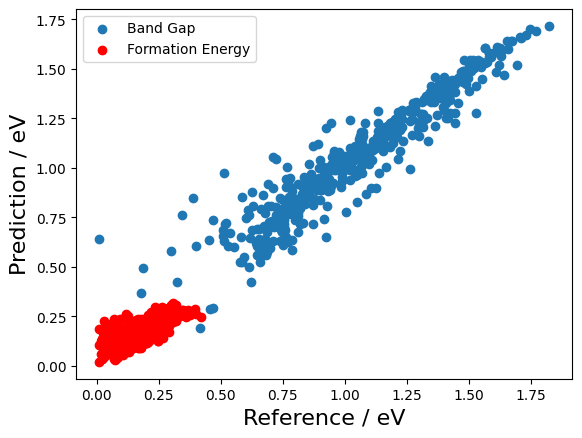

In [24]:
# Visualize error of the test set
plt.scatter(y_valid1, nn_preds1, label="Band Gap")
plt.scatter(y_valid2, nn_preds2, label="Formation Energy", color="red")
plt.xlabel("Reference / eV", fontsize=16)
plt.ylabel("Prediction / eV", fontsize=16)
plt.legend()
plt.show()

What can we do to further boost the performance of our models? If you have a look at out input data, you'll see that the amount of information we provide is very limited, and in addition we use only a small dataset. Partially, this can be fixed by providing additional information to our model as input features. But where does this data come from? Fortunately, the dataset comprises not only the data we used so far, but in addition the structural data of all compounds. This means, in addition to the provided data we can increase the amount of information by extracting chemical relevant informations from the files. Below are several ideas how to do this, feel free to extend it by your own method. Note that all of the function below rely on an "Atom" object from ASE, which is used to store the structural data. If you want to know more about this, you can read it up [here](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).

In [18]:
def volume(atom):
    """
    Calculates the volume of a unit cell
    ### Input ###
    atom: ASE atom object
    ### Output ### 
    vol: Volume of the unit cell
    """
    vol = atom.get_volume()
    return vol


def valence_d_electrons(atom):
    """
    Calculates the fraction of d electrons in the valence shell
    ### Input ###
    atom: ASE atom object
    ### Output ### 
    d_frac: relative fraction of d_electrons 
    """
    # Count number of d-electrons
    Z = atom.get_atomic_numbers()
    n_d = np.sum((Z == 31) * 10 + (Z == 49) * 10)
    # Count number of valence electrons
    n_v = np.sum((Z == 31) * 13 + (Z == 49) * 13 + (Z == 13) * 3 + (Z == 8) * 6)
    d_frac = n_d / n_v
    return d_frac

def mean_metal_distance(atom):
    """
    Calculates the mean distance between metal centres in the unit cell
    Note that this excludes all neighbouring unit cells
    ### Input ###
    atom: ASE atom object
    ### Output ### 
    mean: Mean metal-metal distance
    """
    pos = atom.positions
    # Get metal atom positions
    Z = atom.get_atomic_numbers()
    metal_pos = pos[Z != 8]
    mean = 0
    N = metal_pos.shape[0]
    # Loop over metal atoms, avoid double counting
    for i, pos1 in enumerate(metal_pos[:-1]):
        d = np.linalg.norm(metal_pos[(i + 1):] - pos1, axis=1)
        mean += np.sum(d) / (N - i - 1)
    # Divide by number of metal atoms - 1
    mean /= i
    return mean


def mean_oxygen_distance(atom):
    """
    Calculates the mean distance between metal centres in the unit cell
    Note that this excludes all neighbouring unit cells
    ### Input ###
    atom: ASE atom object
    ### Output ### 
    mean: Mean metal-oxygen distance
    """
    pos = atom.positions
    # get metal + oxygen positions
    Z = atom.get_atomic_numbers()
    metal_pos = pos[Z != 8]
    oxygen_pos = pos[Z == 8]
    mean = 0
    N = metal_pos.shape[0]
    # Loop over all metals
    for i, pos1 in enumerate(oxygen_pos):
        d = np.linalg.norm(metal_pos - pos1, axis=1)
        # Add to mean
        mean += np.sum(d) / N
    # Divide by number of oxygen atoms
    mean /= (i + 1)
    return mean

Using ASE, we now use the predefined functions to improve the quality of our input features. 

In [19]:
train_volume = np.zeros(train_df.shape[0])
train_d = np.zeros(train_df.shape[0])
train_m_dist = np.zeros(train_df.shape[0])
train_o_dist = np.zeros(train_df.shape[0])

for i in train_df.index:
    filename = f"nomad_2018_kaggle_dataset/train/{i+1}/geometry.xyz"
    atom = read_aims(filename)
    train_volume[i] = volume(atom)
    train_d[i] = valence_d_electrons(atom)
    train_m_dist[i] = mean_metal_distance(atom)
    train_o_dist[i] = mean_oxygen_distance(atom)

    # Feel free to add further properties here

features_df["Volume"] = (train_volume - train_volume.mean()) / train_volume.std()
features_df["d-Electrons"] = (train_d - train_d.mean()) / train_d.std()
features_df["MeanMDistance"] = (train_m_dist - train_m_dist.mean()) / train_m_dist.std()
features_df["MeanODistance"] = (train_o_dist - train_o_dist.mean()) / train_o_dist.std()
input_features = features_df.shape[-1]
optimizer = keras.optimizers.SGD(learning_rate=learning_rate) 
model = generate_NN(n_layers, n_features, input_features, 2, activation, optimizer, reg=regularization)

Lets see how this works: 

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(features_df, Targets_df, test_size=0.2, random_state=2017)
output = model.fit(np.array(X_train).astype('float32'), np.array(y_train).astype('float32'), epochs=iterations, batch_size=batch_size, callbacks=keras.callbacks.TensorBoard())

Epoch 1/200
96/96 [==============================] - 0s 971us/step - loss: 0.1368
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0331
Epoch 4/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 6/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 8/200
96/96 [==============================] - 0s 938us/step - loss: 0.0174
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 10/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 11/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 12/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 13/200
96/96 [=============

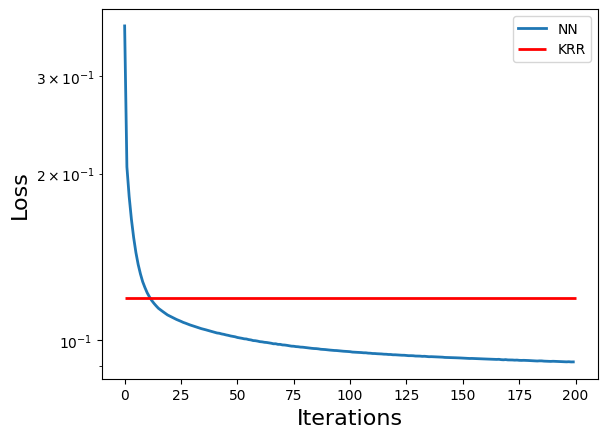

In [21]:
output.history.keys()
loss=output.history["loss"]
plt.plot(np.sqrt(loss), label="NN", lw=2)
plt.hlines(rsme_total, 0, 200, color="red", lw=2, label="KRR")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.yscale("log")
plt.legend()

In [26]:
pred = model.predict(np.array(X_valid, dtype=np.float32))
pred_train = model.predict(np.array(X_train, dtype=np.float32))
model.evaluate(np.array(X_valid, dtype=np.float32), np.array(y_valid, dtype=np.float32))
y_valid3 = np.array(y_valid)[:, 0]
y_valid4 = np.array(y_valid)[:, 1]
nn_preds3 = pred[:, 0]
nn_preds4 = pred[:, 1]
rsme_valid1 = np.sqrt(mean_squared_error(y_valid3,nn_preds3))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid4,nn_preds4))

rsme_total = np.sqrt(rsme_valid1*rsme_valid1+rsme_valid2*rsme_valid2)
print('RSME for formation energy:')
print(rsme_valid1)
print('RSME for band gap:')
print(rsme_valid2)
print('RSME for total:')
print(rsme_total)

15/15 [==============================] - 0s 873us/step - loss: 0.0090
RSME for formation energy:
0.10174962980777408
RSME for band gap:
0.05587351961230717
RSME for total:
0.11608116711976126


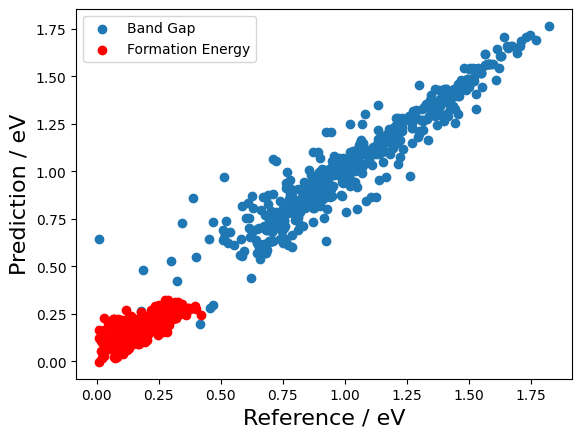

In [27]:
plt.scatter(y_valid3, nn_preds3, label="Band Gap")
plt.scatter(y_valid4, nn_preds4, label="Formation Energy", color="red")
plt.xlabel("Reference / eV", fontsize=16)
plt.ylabel("Prediction / eV", fontsize=16)
plt.legend()
plt.show()